# Berg quarry - preprocessing

In [1]:
# Import packages
import pandas as pd
import numpy as np
import pyproj
import os
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.features import DivIcon
# Import local package
from borehole_analysis import processing as bap

In [2]:
# Load jupyter extension to reload packages before executing user code.
# This is useful for local packages when code is still being changed
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload

In [3]:
# Reload all packages (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

**To Do**

* Normalize GSD proportions to 100  
* 
* ~~Check Lambert 72 spatial reference code (ESRI:103300, EPSG:31300 or EPSG:31370)~~
* ~~Write a function that fills in missing code_geol codes in df_Berg_washed based on code_geol of df_Berg_geology~~ --> Done manually due to issues
* ~~Write a function to combine the washed rows per hole_id in the subsetted dataframes~~
* ~~Write a function that extracts different unitlayers of boreholes --> This can be based on geol_type classification and thus could be done by extracting a dataframe for each layer~~
* ~~Which boreholes do not have GSD data in washed?~~
* ~~Write a function to average the grain size measurements per geol_code per hole_id~~
* ~~Write a function to recombine the subsetted dataframes with their unique rows (set hole_id as index1, code_geol as index2)~~

In [4]:
# Set coordinates projections
lam72 = pyproj.Proj(init="ESRI:103300") # Lambert 72
wgs84 = pyproj.Proj(init="EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth

## Files

1. collar 92 boreholes
2. survey 92 boreholes
3. geology 80 boreholes
4. washed 92 boreholes

In [5]:
# Set directory path
path_Berg = "../_DATA/Berg_groeve/"

### 1&2. Berg collar and survey
* Coordinates
* Elevation
* Year

In [6]:
# Create DataFrames from csv files
df_Berg_collar = pd.read_csv(path_Berg + "Berg_collar.csv", sep=";") # Basic information
df_Berg_survey = pd.read_csv(path_Berg + "Berg_survey.csv", sep=";") # Doesn't add new information

# Drop unnecessary columns
df_Berg_collar.drop(["hole_path"], axis=1, inplace=True)
df_Berg_collar.head()

In [7]:
# Transform coordinates from Lambert72 to WGS84
Berg_lon, Berg_lat = pyproj.transform(lam72, wgs84, df_Berg_collar["x"].values, df_Berg_collar["y"].values)

In [8]:
# Change Lambert72 coordinates to WGS84 coordinates in degrees
df_Berg_collar["x"] = Berg_lat
df_Berg_collar["y"] = Berg_lon
df_Berg_collar.rename(columns={"x" : "lat", 
                               "y" : "lon", 
                               "z" : "elevation"}, inplace=True)
df_Berg_collar.tail()

,hole_id,max_depth,lat,lon,elevation,year
87,ECO_09_01,52.0,50.959702,5.624494,90.69,2009
88,ECO_09_02,35.0,50.961401,5.622375,88.09,2009
89,ECO_09_03,35.0,50.961114,5.624641,90.01,2009
90,ECO_09_04,35.0,50.960865,5.626902,88.10,2009
91,ECO_09_05,52.0,50.963352,5.622881,89.59,2009


In [9]:
# Create map
Berg_map = folium.Map()

# Add boreholes to map
for index, row in df_Berg_collar.iterrows():
    # Add borehole marker
    marker = folium.features.Circle(radius=5, 
                                    location=[row["lat"], row["lon"]], 
                                    color='crimson',
                                    fill=True,
                                    fill_color='crimson',
                                    fill_opacity=1)
    marker.add_to(Berg_map)
    # Add borehole text
    text = folium.Marker(location=[row["lat"], row["lon"]], 
                         popup="year: " + str(row["year"]),
                         icon=DivIcon(icon_size=(150,36), 
                                      icon_anchor=(-1,-1), 
                                      html='<div style="font-size: 8pt">' + row["hole_id"] +'</div>'))
    text.add_to(Berg_map)

# Map bounding coordinates
lon_max, lat_max= df_Berg_collar["lon"].max(), df_Berg_collar["lat"].max()
lon_min, lat_min =  df_Berg_collar["lon"].min(), df_Berg_collar["lat"].min()   
    
# Set bounds of map to display
Berg_map.fit_bounds([(lat_max, lon_max), (lat_min, lon_min)])

# Show map
Berg_map

In [134]:
# Only save file if it doesn't xist yet
if not os.path.isfile("..\_RESULTS\coordinates.csv"):
    # Save Berg_collar to .csv
    df_Berg_collar.to_csv("..\_RESULTS\coordinates.csv", index=False)
    print("saved")

### 3. Berg geology
* Depth intervals of geological units

**code_geol:**
* OVB : Overburden
* GR : Gravel
* TZ : Tussenzand
* BC : Bruinkool
* IZ : Industriezand
* GZ : Glas zand (glauconitisch)

In [10]:
# Load Berg_geology data
df_Berg_geology = pd.read_csv(path_Berg + "Berg_geology.csv", sep=";") # Geology codes per interval

In [11]:
# Change column order
df_Berg_geology = df_Berg_geology[["hole_id", "depth_from", "depth_to", "geol_code100"]]
# Change column name of geology codes
df_Berg_geology.rename(columns={"geol_code100" : "code_geol"}, inplace=True)

In [12]:
# Categorize code_geol column
df_Berg_geology["code_geol"] = df_Berg_geology["code_geol"].astype("category")
# Change category order
df_Berg_geology["code_geol"] = df_Berg_geology["code_geol"].cat.reorder_categories(["OVB", "GR", "TZ", "BC", "IZ", "GZ"], ordered=True)
df_Berg_geology.head()

,hole_id,depth_from,depth_to,code_geol
0,201,20.0,30.0,TZ
1,201,30.0,31.0,BC
2,201,31.0,42.5,IZ
3,677_2,16.0,27.0,TZ
4,677_2,27.0,30.0,BC


### 4. Berg washed
* Sample id's
* Depth intervals of measurements with according geological unit code
* 11 Grain size classes (gravel to z_0)
* Clay analysis parameters

**code_geol:**
* OVB : Overburden
* TZ : Tussenzand
* BC : Bruinkool
* IZ : Industriezand
* GZ : Glas zand (glauconitisch)

In [13]:
# Load Berg_washed data
df_Berg_washed = pd.read_csv(path_Berg + "Berg_washed_mod.csv", sep=";") # GSD data by sieve analysis
# Capitalize code geol
df_Berg_washed["code_geol"] = df_Berg_washed["code_geol"].str.upper()
# Set name of DataFrame
df_Berg_washed.name = "df_Berg_Washed"

In [14]:
# Categorize code_geol column
df_Berg_washed["code_geol"] = df_Berg_washed["code_geol"].astype("category")
# Change category order
df_Berg_washed["code_geol"] = df_Berg_washed["code_geol"].cat.reorder_categories(["OVB", "TZ", "BC", "IZ", "GZ"], ordered=True)
# Subset DataFrame with columns of interest 
df_Berg_washed = df_Berg_washed[["hole_id", "samp_id", "depth_from", "depth_to", "code_geol", "gravel", "z_1000", 
                                 "z_710", "z_500", "z_355", "z_250", "z_180", "z_125", "z_90", "z_63", "z_0", 
                                 "afa", "ags", "clay", "samp_id_clay", "spec_surf", "FinMod"]]
#df_Berg_washed.drop(["al_wa", "ca_wa", "fe_wa", "k_wa", "mg_wa", "na_wa", "si_wa", "ti_wa"], 
#                    inplace=True, axis=1) # empty columns
df_Berg_washed.head()

,hole_id,samp_id,depth_from,depth_to,code_geol,gravel,z_1000,z_710,z_500,z_355,...,z_125,z_90,z_63,z_0,afa,ags,clay,samp_id_clay,spec_surf,FinMod
0,201,NaN,-0.83,0.00,GZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201,NaN,0.00,10.48,GZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201,NaN,10.48,11.94,GZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201,NaN,11.94,19.50,GZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201,NaN,19.50,22.00,GZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# List with borehole ids
hole_ids = df_Berg_washed["hole_id"].unique()
# Initialize boreholes with/without GSD lists
hole_ids_withoutGSD = []
hole_ids_withGSD = []

# Loop through every borehole in washed dataframe
for hole_id in hole_ids:
    hole = df_Berg_washed[df_Berg_washed["hole_id"] == hole_id]
    # Check if all GSD for z_1000 of borehole are NaN
    # append borehole to withoutGSD if True
    if hole["z_1000"].isnull().sum() == hole.shape[0]:
        hole_ids_withoutGSD.append(hole_id)
    # append borehole to withGSD if False
    else:
        hole_ids_withGSD.append(hole_id)
       
print("There are", len(hole_ids_withGSD), "boreholes with GSD data")
print("There are", len(hole_ids_withoutGSD), "boreholes without GSD data")

There are 50 boreholes with GSD data
There are 42 boreholes without GSD data


In [16]:
# Create washed dataframe with GSD data
df_Berg_washed_withGSD = df_Berg_washed.copy()
for hole_id in hole_ids_withoutGSD:
    indexer = list(df_Berg_washed_withGSD[df_Berg_washed_withGSD["hole_id"] == hole_id].index)
    df_Berg_washed_withGSD.drop(indexer, inplace=True)

# Aseert number of boreholes equals 50
assert len(df_Berg_washed_withGSD["hole_id"].unique()) == len(hole_ids_withGSD)

In [17]:
# Create washed dataframe without GSD data
df_Berg_washed_withoutGSD = df_Berg_washed.copy()
for hole_id in hole_ids_withGSD:
    indexer = list(df_Berg_washed_withoutGSD[df_Berg_washed_withoutGSD["hole_id"] == hole_id].index)
    df_Berg_washed_withoutGSD.drop(indexer, inplace=True)
    
# Aseert number of boreholes equals 42
assert len(df_Berg_washed_withoutGSD["hole_id"].unique()) == len(hole_ids_withoutGSD)

In [18]:
df_Berg_washed_withGSD_clean = df_Berg_washed_withGSD.drop(["gravel", "clay", "samp_id_clay", "spec_surf", "FinMod"], axis=1)
df_Berg_washed_withGSD_clean.head()

,hole_id,samp_id,depth_from,depth_to,code_geol,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0,afa,ags
136,BRG_01_01,NaN,0.00,0.09,OVB,0.0,0.1,0.5,4.1,25.0,51.5,15.5,2.7,0.5,0.0,61.0,235.0
137,BRG_01_01,NaN,0.09,6.00,TZ,0.0,0.1,0.5,4.1,25.0,51.5,15.5,2.7,0.5,0.0,61.0,235.0
138,BRG_01_01,NaN,6.00,8.00,TZ,0.0,0.0,0.2,2.9,27.2,58.2,11.0,0.4,0.0,0.0,59.0,238.0
139,BRG_01_01,NaN,8.00,9.90,TZ,0.0,0.0,0.3,7.8,48.4,38.1,5.0,0.2,0.0,0.0,52.0,271.0
140,BRG_01_01,NaN,9.90,10.00,BC,0.0,0.0,0.3,7.8,48.4,38.1,5.0,0.2,0.0,0.0,52.0,271.0


In [19]:
# Number of rows with percentage > 5 for sum of 3 largest grain size classes
df_Berg_washed_withGSD_clean["hole_id"][df_Berg_washed_withGSD_clean[["z_1000","z_710","z_500"]].sum(axis=1) > 5].value_counts().sum()

70

In [20]:
# Number of rows with percentage > 5 for sum of 3 smallest grain size classes
df_Berg_washed_withGSD_clean["hole_id"][df_Berg_washed_withGSD_clean[["z_63","z_0"]].sum(axis=1) > 5].value_counts().sum()

43

___

## Tests

In [111]:
testers = df_Berg_washed_withGSD_clean[df_Berg_washed_withGSD_clean["hole_id"] == "BRG_01_01"].drop(["hole_id", "samp_id", "depth_from", "depth_to", "afa", "ags"], axis=1)
testers_IZ = testers[tester["code_geol"] == "IZ"].drop("code_geol", axis=1)
testers_IZ.dropna(inplace=True)
testers_IZ.replace(0.0, 0.00001, inplace=True)
testers_IZ = testers_IZ.divide(testers_IZ.sum(axis=1), axis=0) * 100
testers_IZ

,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0
143,0.00001,0.00001,0.00001,0.600600,11.611606,64.464432,23.023011,0.300300,0.00001,0.00001
144,0.00001,0.00001,0.00001,0.100000,9.099995,68.299966,22.099989,0.400000,0.00001,0.00001
145,0.00001,0.00001,0.00001,0.200000,16.199992,66.299967,17.099991,0.200000,0.00001,0.00001
146,0.00001,0.00001,0.00001,0.200200,17.617609,71.071035,11.011005,0.100100,0.00001,0.00001
147,0.00001,0.00001,0.00001,0.700700,23.723712,65.165133,10.310305,0.100100,0.00001,0.00001
148,0.00001,0.00001,0.00001,0.800000,20.599990,67.399966,10.999995,0.200000,0.00001,0.00001
149,0.00001,0.00001,0.10020,1.402805,20.541074,65.931837,11.823643,0.200401,0.00001,0.00001


In [112]:
testers_ln = np.log(testers_IZ)
testers_ln

,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0
143,-11.511925,-11.511925,-11.511925,-0.509826,2.452005,4.166114,3.136494,-1.202973,-11.511925,-11.511925
144,-11.512926,-11.512926,-11.512926,-2.302586,2.208274,4.223909,3.095577,-0.916291,-11.512926,-11.512926
145,-11.512926,-11.512926,-11.512926,-1.609438,2.785011,4.194189,2.839078,-1.609438,-11.512926,-11.512926
146,-11.511925,-11.511925,-11.511925,-1.608438,2.868899,4.263680,2.398895,-2.301585,-11.511925,-11.511925
147,-11.511925,-11.511925,-11.511925,-0.355675,3.166475,4.176925,2.333144,-2.301585,-11.511925,-11.511925
148,-11.512926,-11.512926,-11.512926,-0.223144,3.025291,4.210645,2.397895,-1.609438,-11.512926,-11.512926
149,-11.510924,-11.510924,-2.300583,0.338474,3.022426,4.188621,2.470101,-1.607436,-11.510924,-11.510924


In [113]:
testers_clr = testers_ln.subtract(testers_ln.mean(axis=1), axis=0)
testers_clr

,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0
143,-6.560144,-6.560144,-6.560144,4.441956,7.403786,9.117895,8.088275,3.748808,-6.560144,-6.560144
144,-6.387351,-6.387351,-6.387351,2.822989,7.333849,9.349484,8.221152,4.209283,-6.387351,-6.387351
145,-6.416403,-6.416403,-6.416403,3.487084,7.881534,9.290712,7.935601,3.487084,-6.416403,-6.416403
146,-6.318108,-6.318108,-6.318108,3.585380,8.062717,9.457498,7.592713,2.892233,-6.318108,-6.318108
147,-6.457891,-6.457891,-6.457891,4.698359,8.220509,9.230959,7.387178,2.752449,-6.457891,-6.457891
148,-6.536588,-6.536588,-6.536588,4.753194,8.001629,9.186983,7.374233,3.366900,-6.536588,-6.536588
149,-7.517715,-7.517715,1.692626,4.331683,7.015636,8.181831,6.463310,2.385773,-7.517715,-7.517715


In [114]:
testers_clr_mean = testers_clr.mean()
testers_clr_mean

z_1000   -6.599171
z_710    -6.599171
z_500    -5.283409
z_355     4.017235
z_250     7.702808
z_180     9.116480
z_125     7.580352
z_90      3.263219
z_63     -6.599171
z_0      -6.599171
dtype: float64

In [115]:
testers_recon_mean = np.exp(testers_clr_mean) / np.exp(testers_clr_mean).sum() * 100
testers_recon_mean

z_1000     0.000010
z_710      0.000010
z_500      0.000038
z_355      0.415784
z_250     16.576450
z_180     68.146153
z_125     14.665919
z_90       0.195615
z_63       0.000010
z_0        0.000010
dtype: float64

In [123]:
testers_IZ.mean(axis=0, skipna=True)

z_1000     0.000010
z_710      0.000010
z_500      0.014323
z_355      0.572044
z_250     17.056282
z_180     66.947477
z_125     15.195420
z_90       0.214414
z_63       0.000010
z_0        0.000010
dtype: float64

In [116]:
testers_recon = np.exp(testers_clr).divide(np.exp(testers_clr).sum(axis=1), axis=0) * 100
testers_recon

,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0
143,0.00001,0.00001,0.00001,0.600600,11.611606,64.464432,23.023011,0.300300,0.00001,0.00001
144,0.00001,0.00001,0.00001,0.100000,9.099995,68.299966,22.099989,0.400000,0.00001,0.00001
145,0.00001,0.00001,0.00001,0.200000,16.199992,66.299967,17.099991,0.200000,0.00001,0.00001
146,0.00001,0.00001,0.00001,0.200200,17.617609,71.071035,11.011005,0.100100,0.00001,0.00001
147,0.00001,0.00001,0.00001,0.700700,23.723712,65.165133,10.310305,0.100100,0.00001,0.00001
148,0.00001,0.00001,0.00001,0.800000,20.599990,67.399966,10.999995,0.200000,0.00001,0.00001
149,0.00001,0.00001,0.10020,1.402805,20.541074,65.931837,11.823643,0.200401,0.00001,0.00001


In [117]:
testers_recon/testers_IZ

,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0
143,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
144,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
145,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
146,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
147,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
148,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
149,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


___

In [118]:
testers_IZ

,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0
143,0.00001,0.00001,0.00001,0.600600,11.611606,64.464432,23.023011,0.300300,0.00001,0.00001
144,0.00001,0.00001,0.00001,0.100000,9.099995,68.299966,22.099989,0.400000,0.00001,0.00001
145,0.00001,0.00001,0.00001,0.200000,16.199992,66.299967,17.099991,0.200000,0.00001,0.00001
146,0.00001,0.00001,0.00001,0.200200,17.617609,71.071035,11.011005,0.100100,0.00001,0.00001
147,0.00001,0.00001,0.00001,0.700700,23.723712,65.165133,10.310305,0.100100,0.00001,0.00001
148,0.00001,0.00001,0.00001,0.800000,20.599990,67.399966,10.999995,0.200000,0.00001,0.00001
149,0.00001,0.00001,0.10020,1.402805,20.541074,65.931837,11.823643,0.200401,0.00001,0.00001


In [121]:
testers_IZ.mean(axis=0, skipna=True)

z_1000     0.000010
z_710      0.000010
z_500      0.014323
z_355      0.572044
z_250     17.056282
z_180     66.947477
z_125     15.195420
z_90       0.214414
z_63       0.000010
z_0        0.000010
dtype: float64

___

### Geology & Washed dataframes - operations
* Compare available bore holes
* Compare geol_code intervals
* Subset dataframes according to geol_code
* Combine boreholes in subsets to depth intervals (+ averaging log? GSD data)
    - Dataframes to use in Surfer Kriging
* Recombine subsets to one overview dataframe

In [142]:
# Boreholes in collar/washed (90 boreholes) but not in geology (80 boreholes)
set(df_Berg_collar["hole_id"].unique()) - set(df_Berg_geology["hole_id"].unique())

{'B11_90_1',
 'B11_90_2',
 'B11_90_3',
 'B11_90_4',
 'BRG_11_01',
 'BRG_11_02',
 'BRG_11_03',
 'BRG_11_04',
 'BRG_11_05',
 'BRG_11_06',
 'BRG_11_07',
 'BRG_11_08',
 'BRG_96_BE04',
 'BRG_96_BE05'}

In [143]:
# Boreholes in washed without code_geol information
empty = df_Berg_washed[df_Berg_washed["code_geol"].isnull().values]["hole_id"].unique()
empty

array(['BRG_11_01', 'BRG_11_02', 'BRG_11_03', 'BRG_11_04', 'BRG_11_05',
       'BRG_11_06', 'BRG_11_07', 'BRG_11_08'], dtype=object)

Boreholes without code_geol info in both geology and washed dataframes (8):  
They do have GSD data, however
- BRG_11_01
- BRG_11_02
- BRG_11_03
- BRG_11_04
- BRG_11_05
- BRG_11_06
- BRG_11_07
- BRG_11_08

Boreholes present in washed but not in geology dataframe (4):
- B11_90_1
- B11_90_2
- B11_90_3
- B11_90_4

In [144]:
subsets_Berg_geology = bap.subset_df_based_on_categories(df_Berg_geology, "code_geol")
#del subsets_Berg_geology[np.nan]
subsets_Berg_geology["IZ"].head()

,hole_id,depth_from,depth_to,code_geol
2,201,31.0,42.5,IZ
5,677_2,30.0,39.0,IZ
8,877_3,28.0,38.0,IZ
11,877_4,33.0,43.0,IZ
14,977_6,30.0,45.0,IZ


In [145]:
subsets_Berg_washed = bap.subset_df_based_on_categories(df_Berg_washed, "code_geol")
# Delete subset without code_geol information
del subsets_Berg_washed[np.nan]
subsets_Berg_washed["IZ"].head()

,hole_id,samp_id,depth_from,depth_to,code_geol,gravel,z_1000,z_710,z_500,z_355,...,z_125,z_90,z_63,z_0,afa,ags,clay,samp_id_clay,spec_surf,FinMod
19,877_3,NaN,28.83,38.57,IZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,B11_90_1,NaN,8.75,19.05,IZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,B11_90_3,NaN,13.59,22.50,IZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,B11_90_4,NaN,4.40,15.51,IZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,B34,NaN,14.00,15.05,IZ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- hole_ids in subsets_unique_geology with:
    - OVB: 2
    - GR: 5
    - TZ: 71
    - BC: 42
    - IZ: 78
    - GZ: 37
- hole_ids in subsets_unique_washed with:
    - OVB: 59
    - GR: /
    - TZ: 69
    - BC: 48
    - IZ: 72
    - GZ: 71

In [146]:
# eerst normailseren en dan gemiddelde of andersom?

In [147]:
subsets_unique_geology  = {}

for cat, df in subsets_Berg_geology.items():
    subsets_unique_geology[cat] = bap.combine_id_rows_simple(df, cat, "hole_id", "depth_from", "depth_to")

In [148]:
subsets_unique_washed  = {}

for cat, df in subsets_Berg_washed.items():
    subsets_unique_washed[cat] = bap.combine_id_rows_simple(df, cat, "hole_id", "depth_from", "depth_to")

In [149]:
subsets_unique_averages_washed  = {}

for cat, df in subsets_Berg_washed.items():
    subsets_unique_averages_washed[cat] = bap.combine_id_rows_complex(df, cat, "hole_id", "depth_from", "depth_to")

GZ merge: (71, 20)
OVB merge: (59, 20)
TZ merge: (69, 20)
BC merge: (48, 20)
IZ merge: (72, 20)


In [150]:
subsets_unique_averages_washed["GZ"].round(2).tail()

,hole_id,depth_from,depth_to,code_geol,gravel,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0,afa,ags,clay,spec_surf,FinMod
66,BRG_97_05,24.17,25.0,GZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,ECO_09_01,35.97,52.0,GZ,NaN,0.05,0.01,0.78,2.81,13.59,40.49,35.99,5.36,0.42,0.39,68.82,206.71,NaN,NaN,NaN
68,ECO_09_02,34.07,35.0,GZ,NaN,0.10,0.00,0.10,0.20,12.70,75.50,10.70,0.50,0.10,0.10,61.00,220.00,NaN,NaN,NaN
69,ECO_09_04,32.10,35.0,GZ,NaN,0.00,0.00,0.00,0.17,17.30,63.13,18.00,0.43,0.20,0.70,63.00,217.33,NaN,NaN,NaN
70,ECO_09_05,38.59,52.0,GZ,NaN,0.17,0.03,0.44,2.70,18.71,44.57,29.79,2.79,0.30,0.42,65.21,217.71,NaN,NaN,NaN


In [26]:
# Set hole_id as index level 1 and code_geol as index level 2 and save individual dataframes with coordinates data
writer2 = pd.ExcelWriter("../_RESULTS/Berg_processed_individual.xlsx")

subsets_unique_averages_washed_indexed = {}
for cat, df in subsets_unique_averages_washed.items():
    subsets_unique_averages_washed_indexed[cat] = df.set_index(["hole_id", "code_geol"])
    df_merge = pd.merge(df_Berg_collar, df, left_on="hole_id", right_on="hole_id").set_index("hole_id")
    df_merge.to_excel(writer2, cat)

writer2.save()

In [157]:
# Recombine subsets
recombined = pd.concat(list(subsets_unique_averages_washed.values()), axis=0)
# Only one value per groupby so mean just represents present value
recombined_washed = recombined.groupby(["hole_id", "code_geol"]).mean() 
# Reindex level 1 index so that geological order of layers stays clear
recombined_washed = recombined_washed.reindex(index=["OVB", "TZ", "BC", "IZ", "GZ"], level=1)
recombined_washed.tail()

depth_from  depth_to  gravel    z_1000     z_710  \
hole_id   code_geol                                                     
ECO_09_04 GZ              32.10     35.00     NaN  0.000000  0.000000   
ECO_09_05 OVB              0.00     15.33     NaN  0.100000  0.000000   
          TZ              15.33     18.59     NaN  0.050000  0.025000   
          IZ              18.59     38.59     NaN  0.004762  0.004762   
          GZ              38.59     52.00     NaN  0.171429  0.028571   

                        z_500     z_355      z_250      z_180      z_125  \
hole_id   code_geol                                                        
ECO_09_04 GZ         0.000000  0.166667  17.300000  63.133333  18.000000   
ECO_09_05 OVB        0.100000  1.000000  19.100000  58.000000  20.800000   
          TZ         0.050000  0.825000  18.250000  71.000000   8.850000   
          IZ         0.004762  0.442857  21.295238  67.233333  10.704762   
          GZ         0.442857  2.700000  18.714286  44.571429  29.785714   

                         z_90      z_63       z_0        afa         ags  \
hole_id   code_geol                                                        
ECO_09_04 GZ         0.433333  0.200000  0.700000  63.000000  217.333333   
ECO_09_05 OVB        0.300000  0.200000  0.400000  62.000000  221.000000   
          TZ         0.325000  0.200000  0.350000  59.750000  226.500000   
          IZ         0.133333  0.042857  0.038095  59.047619  227.380952   
          GZ         2.785714  0.300000  0.421429  65.214286  217.714286   

                     clay  spec_surf  FinMod  
hole_id   code_geol                           
ECO_09_04 GZ          NaN        NaN     NaN  
ECO_09_05 OVB         NaN        NaN     NaN  
          TZ          NaN        NaN     NaN  
          IZ          NaN        NaN     NaN  
          GZ          NaN        NaN     NaN

In [28]:
# Count zero values for different code_geol in gsd class
gsd_columns = ["z_1000", "z_710", "z_500", "z_355", "z_250", "z_180", "z_125", "z_90", "z_63", "z_0"]
gsd_counter = {}

for gsd in gsd_columns:
    cat_counter = {}
    for cat, df in subsets_unique_averages_washed.items():
        cat_counter[cat] = df[df[gsd] == 0].shape[0]
        gsd_counter[gsd] = cat_counter
    
gsd_counter

{'z_0': {'BC': 11, 'GZ': 17, 'IZ': 13, 'OVB': 14, 'TZ': 10},
 'z_1000': {'BC': 5, 'GZ': 12, 'IZ': 10, 'OVB': 10, 'TZ': 11},
 'z_125': {'BC': 0, 'GZ': 0, 'IZ': 0, 'OVB': 0, 'TZ': 0},
 'z_180': {'BC': 0, 'GZ': 0, 'IZ': 0, 'OVB': 0, 'TZ': 0},
 'z_250': {'BC': 0, 'GZ': 0, 'IZ': 0, 'OVB': 0, 'TZ': 0},
 'z_355': {'BC': 0, 'GZ': 0, 'IZ': 0, 'OVB': 0, 'TZ': 1},
 'z_500': {'BC': 5, 'GZ': 12, 'IZ': 7, 'OVB': 3, 'TZ': 2},
 'z_63': {'BC': 6, 'GZ': 8, 'IZ': 6, 'OVB': 1, 'TZ': 1},
 'z_710': {'BC': 7, 'GZ': 17, 'IZ': 10, 'OVB': 10, 'TZ': 9},
 'z_90': {'BC': 0, 'GZ': 0, 'IZ': 0, 'OVB': 0, 'TZ': 0}}

In [158]:
writer = pd.ExcelWriter("../_RESULTS/Berg_processed_overview.xlsx")
df_Berg_collar.set_index("hole_id").to_excel(writer, "Berg_collar_combined")
recombined_washed.to_excel(writer, "Berg_washed_recombined", merge_cells=False)
writer.save()
writer.close()

In [29]:
# 8 boreholes are not taken into consideration because of the lack of code_geol info
len(recombined_washed.index.get_level_values("hole_id").unique())

84

Boreholes with significant differences between depth ranges between geology and washed dataframes:  
    - OVB+GR:
        None
    - BC:
        None
    - TZ:
        None
    - IZ:
        - B34 --> recombinations needed
        - B35 --> recombinations needed
        - B83 --> recombinations needed
        - B85 --> recombinations needed
        - B94_6_B1 
        - BRG_16_08
    - GZ:
        - B92_3
        - BRG_16_06
        - More measurements further downhole in washed than in geology
            - BRG_05_05
            - BRG_05_09
            - BRG_05_10
            - BRG_05_12
            - BRG_05_13
            - BRG_05_14
            - BRG_96_02
            - BRG_97_01
            - ECO_09_01
            - ECO_09_05
        
        

### Borehole plotting

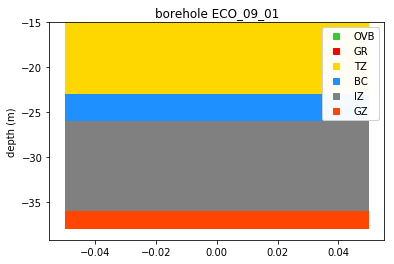

In [30]:
# Geology
bap.plot_borehole(df_Berg_geology, ["ECO_09_01"])

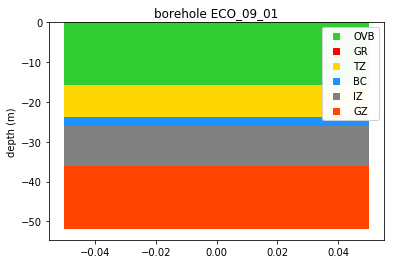

In [31]:
# Washed
bap.plot_borehole(df_Berg_washed, ["ECO_09_01"])

____

### Old code snippets